In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import pandas as pd
import torch

from src import read_dicom, Detector, Siddon
from src.metrics import xcorr2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
colors = ["#e7298a", "#1b9e77", "#d95f02", "#7570b3"]

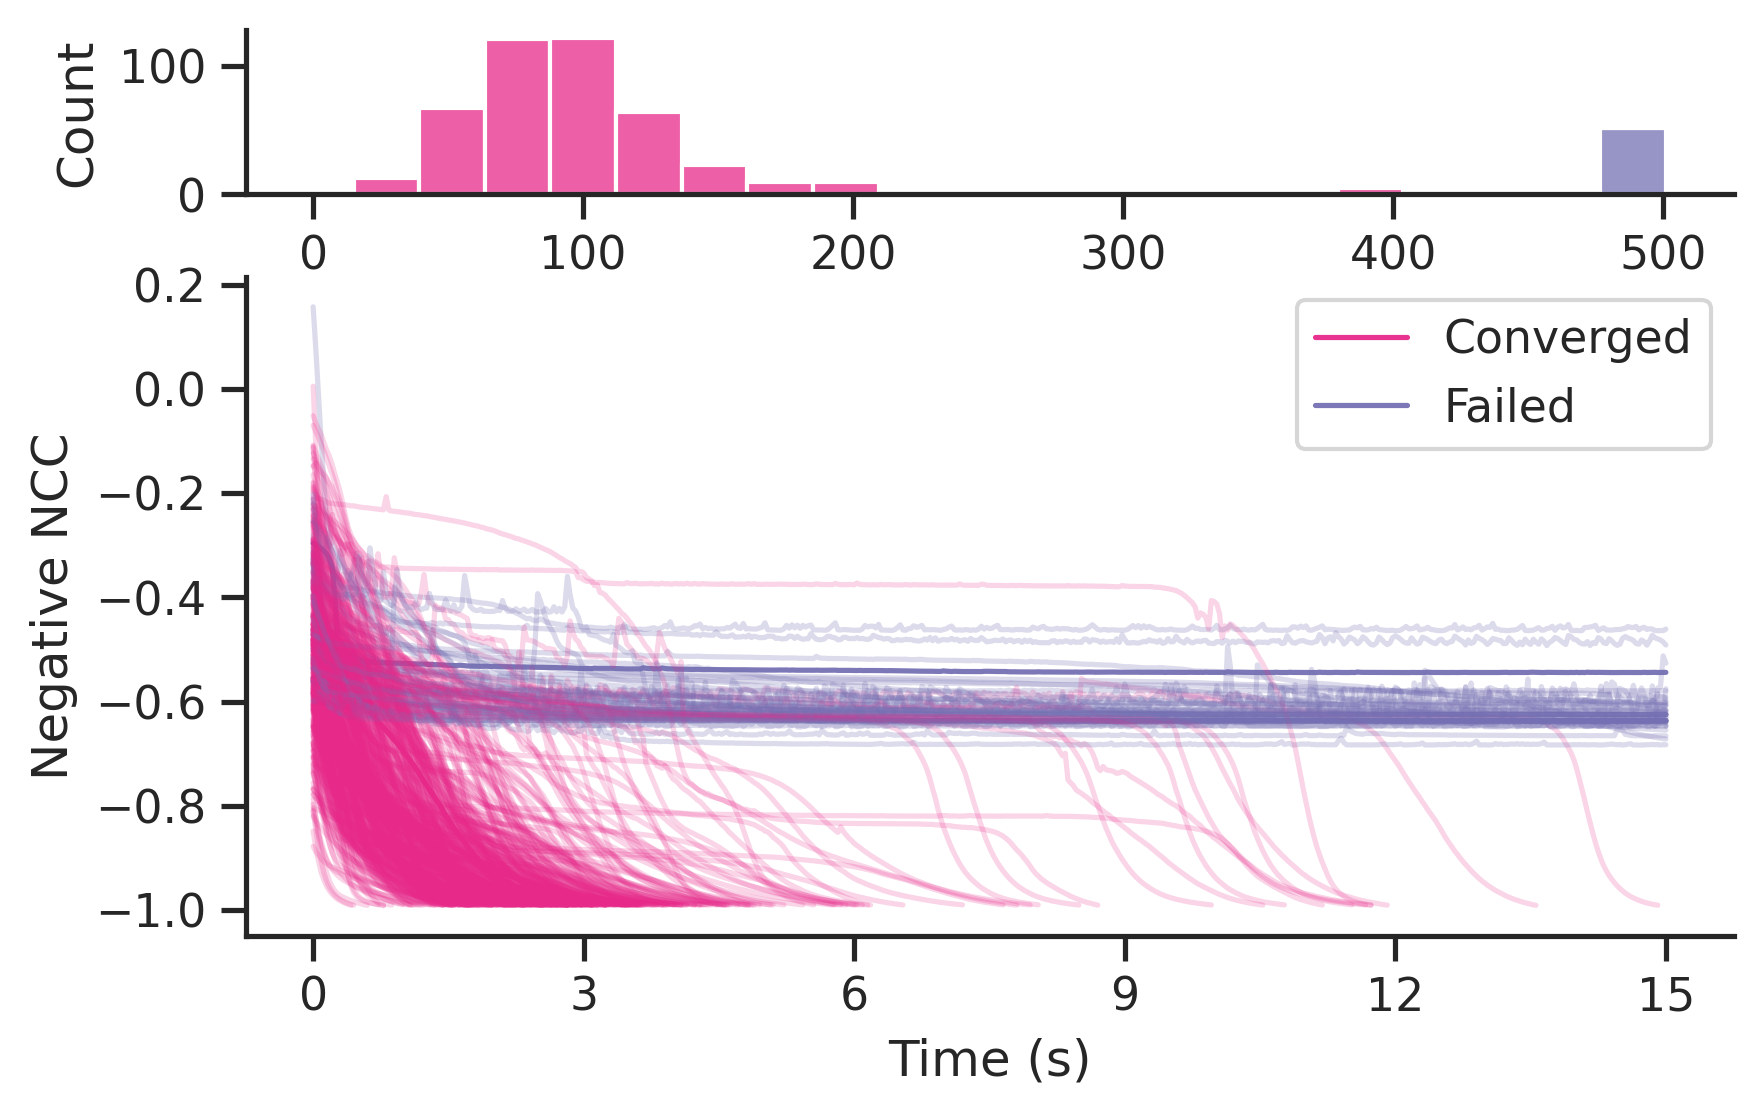

In [33]:
fig = plt.figure(dpi=300, figsize=plt.figaspect(5/8))

gs = gridspec.GridSpec(
    nrows=2, ncols=1,
    height_ratios=[1, 4],
    figure=fig
)
ax1 = plt.subplot(gs[0], sharex=ax4)
ax4 = plt.subplot(gs[1])


csvs = Path("../results/grad_desc/").glob("*.csv")
conv = 0
nconv = 0
output = []

### Plot the training curves
new_1 = True
new_2 = True
new_3 = True
new_4 = True
for csv in csvs:
    try:
        df = pd.read_csv(csv, comment="#")
    except:
        continue
    final_loss = df["loss"].iloc[-1]
    alpha = 0.25
    lw = 1.25
    if final_loss <= -0.99:
        label = "Converged"
        ax4.plot(df["itr"], df["loss"], alpha=0.95 if new_1 else 0.2, lw=lw, c=colors[0], label=label if new_1 else None)
        new_1 = False
    elif final_loss > -.99 and final_loss <= -.82:
        continue
        label="Case 1"
        ax4.plot(df["itr"], df["loss"], alpha=0.95 if new_2 else alpha, lw=lw, c=colors[1], label=label if new_2 else None)
        new_2 = False
    elif final_loss > -.82 and final_loss <= -.69:
        continue
        label="Case 2"
        ax4.plot(df["itr"], df["loss"], alpha=0.95 if new_3 else alpha, lw=lw, c=colors[2], label=label if new_3 else None)
        new_3 = False
    else:
        label="Failed"
        ax4.plot(df["itr"], df["loss"], alpha=0.95 if new_4 else alpha, lw=lw, c=colors[3], label=label if new_4 else None)
        new_4 = False
    
    initial_loss = df["loss"].iloc[0]
    # if initial_loss < -0.5:
        # continue

    n = len(df)
    converged = True if n < 500 else False
    if converged:
        conv += 1
    else:
        nconv += 1

    output.append([converged, label, n, initial_loss, final_loss, csv])
    ax4.set(xlabel="Time (s)", ylabel="Negative NCC")
    # ax4.set(xticks=[0, 3, 6, 9, 12, 18])
    ax4.set_xticks([0, 100, 200, 300, 400, 500])
    ax4.set_xticklabels([0, 3, 6, 9, 12, 15])

ax4.legend()

### Plot the number of iterations
df = pd.DataFrame(output, columns=["converged", "case", "n_iters", "initial_loss", "final_loss", "filename"])
sns.histplot(data=df, x="n_iters", palette=[colors[0],colors[3]], hue="case", legend=False, ax=ax1, bins=20, multiple="stack")
# ax1.spines['left'].set_visible(False)
# ax1.get_yaxis().set_visible(False)
ax1.set(xlabel="# Iterations until convergence")
ax1.set_xticklabels([0, 100, 200, 300, 400, 500])
# ax1.set(xticklabels=[])


#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
# order = [0, 3, 2, 1]
#add legend to plot
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=(1.04, 0.1))

plt.savefig("../figures/optimization.pdf", bbox_inches="tight")
plt.show()

In [34]:
# Remove right KDE
# Add time to histogram plot

In [35]:
df.head()

,converged,case,n_iters,initial_loss,final_loss,filename
0,True,Converged,95,-0.472863,-0.990341,../results/grad_desc/393.csv
1,True,Converged,116,-0.621195,-0.990519,../results/grad_desc/434.csv
2,False,Failed,501,-0.295866,-0.543917,../results/grad_desc/266.csv
3,False,Failed,501,-0.252668,-0.592036,../results/grad_desc/67.csv
4,True,Converged,41,-0.383878,-0.990938,../results/grad_desc/510.csv


## Make DRRs

In [37]:
volume, spacing = read_dicom("../data/cxr/")
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

# def make_drr(theta, phi, gamma, bx, by, bz, sdr=200., height=300, delx=1.75e-2):
def make_drr(theta, phi, gamma, bx, by, bz, sdr=200., height=200, delx=2.5e-2):
    """Detector parameters -> DRR"""
    detector = Detector(
        sdr    = sdr,
        theta  = theta,
        phi    = phi,
        gamma  = gamma,
        bx     = bx,
        by     = by,
        bz     = bz,
        device = device
    )
    source, rays = detector.make_xrays(height, height, delx, delx)
    drr = siddon.raytrace(source, rays)
    return drr, detector.angles, detector.translation

def plot(drr):
    plt.imshow(drr.detach().cpu(), cmap="gray")
    plt.show()
    
def corr(drr, est):
    x = xcorr2()
    loss = x(drr.expand(1, 1, -1, -1), est.expand(1, 1, -1, -1))
    return loss.item()

In [45]:
def plot_est(filename, intermediate_idx, out):
    
    fig, axs = plt.subplots(ncols=4, figsize=plt.figaspect(1/4), dpi=300)
    
    # Ground truth DRR
    theta = torch.pi
    phi = 0
    gamma = torch.pi / 2
    bx = 180
    by = 180
    bz = 166.25
    drr, _, _ = make_drr(theta, phi, gamma, bx, by, bz)
    axs[3].imshow(drr.detach().cpu(), cmap="gray")
    axs[3].set(xticks=[], yticks=[], title="Ground Truth\n")
    
    # Plot initial
    with open(filename, "r") as f:
        params = f.readline()[2:-2]
        t, p, g, x, y, z = [float(param) for param in params.split(",")]
        est, _, _ = make_drr(t, p, g, x, y, z)
        axs[0].imshow(est.detach().cpu(), cmap="gray")
        axs[0].set(title=f"Initial\n-NCC = {-corr(drr,est):.2f}")
        axs[0].set(xticks=[], yticks=[])
        
    # Plot intermediate
    df = pd.read_csv(filename, comment="#")
    t, p, g, x, y, z = df.iloc[intermediate_idx][2:].values
    t += theta
    p += phi
    g += gamma
    x += bx
    y += by
    z += bz
    est, _, _ = make_drr(t, p, g, x, y, z)
    axs[1].imshow(est.detach().cpu(), cmap="gray")
    axs[1].set(title=f"Intermediate\n-NCC = {-corr(drr,est):.2f}")
    axs[1].set(xticks=[], yticks=[])
     
    # Plot last
    t, p, g, x, y, z = df.iloc[-1][2:].values
    t += theta
    p += phi
    g += gamma
    x += bx
    y += by
    z += bz
    est, _, _ = make_drr(t, p, g, x, y, z)
    axs[2].imshow(est.detach().cpu(), cmap="gray")
    axs[2].set(title=f"Final\n-NCC = {-corr(drr,est):.2f}")
    axs[2].set(xticks=[], yticks=[])
    
    plt.savefig(out, bbox_inches="tight")
    plt.show()
    
    del drr, est

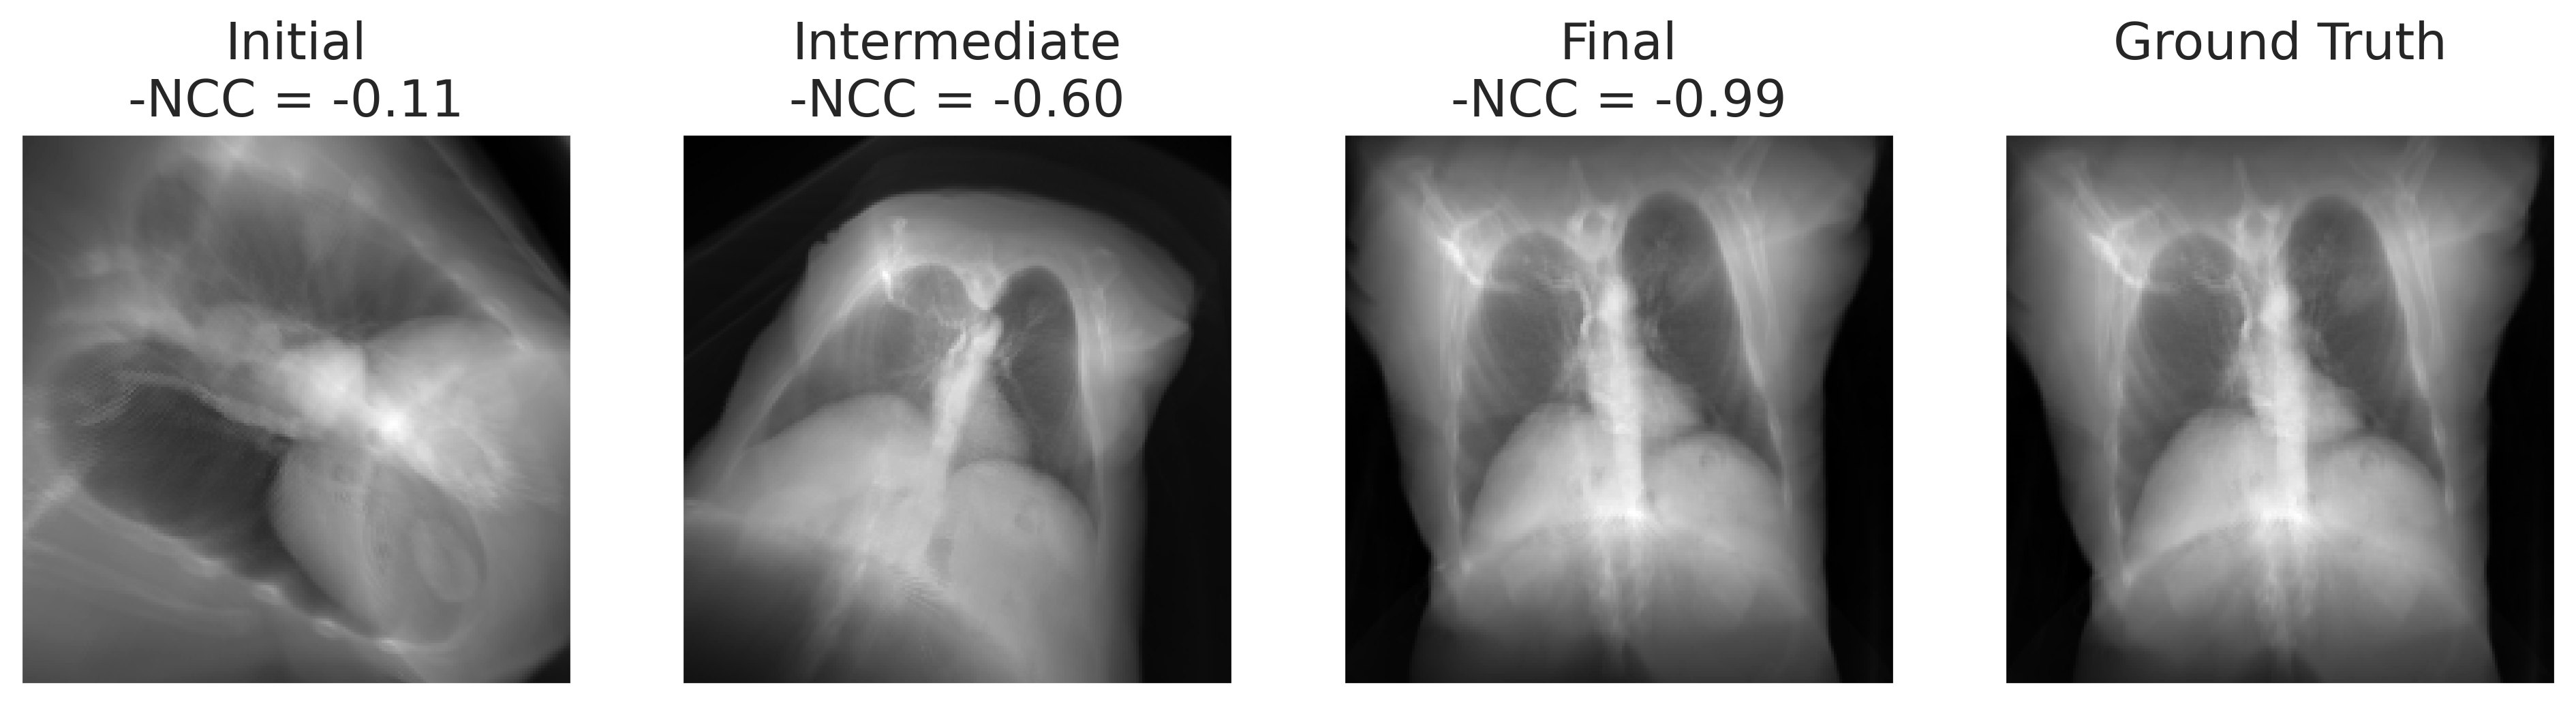

In [46]:
sns.set(font_scale=1.5)
plot_est("../results/grad_desc/300.csv", 25, "../figures/converged-1.pdf")

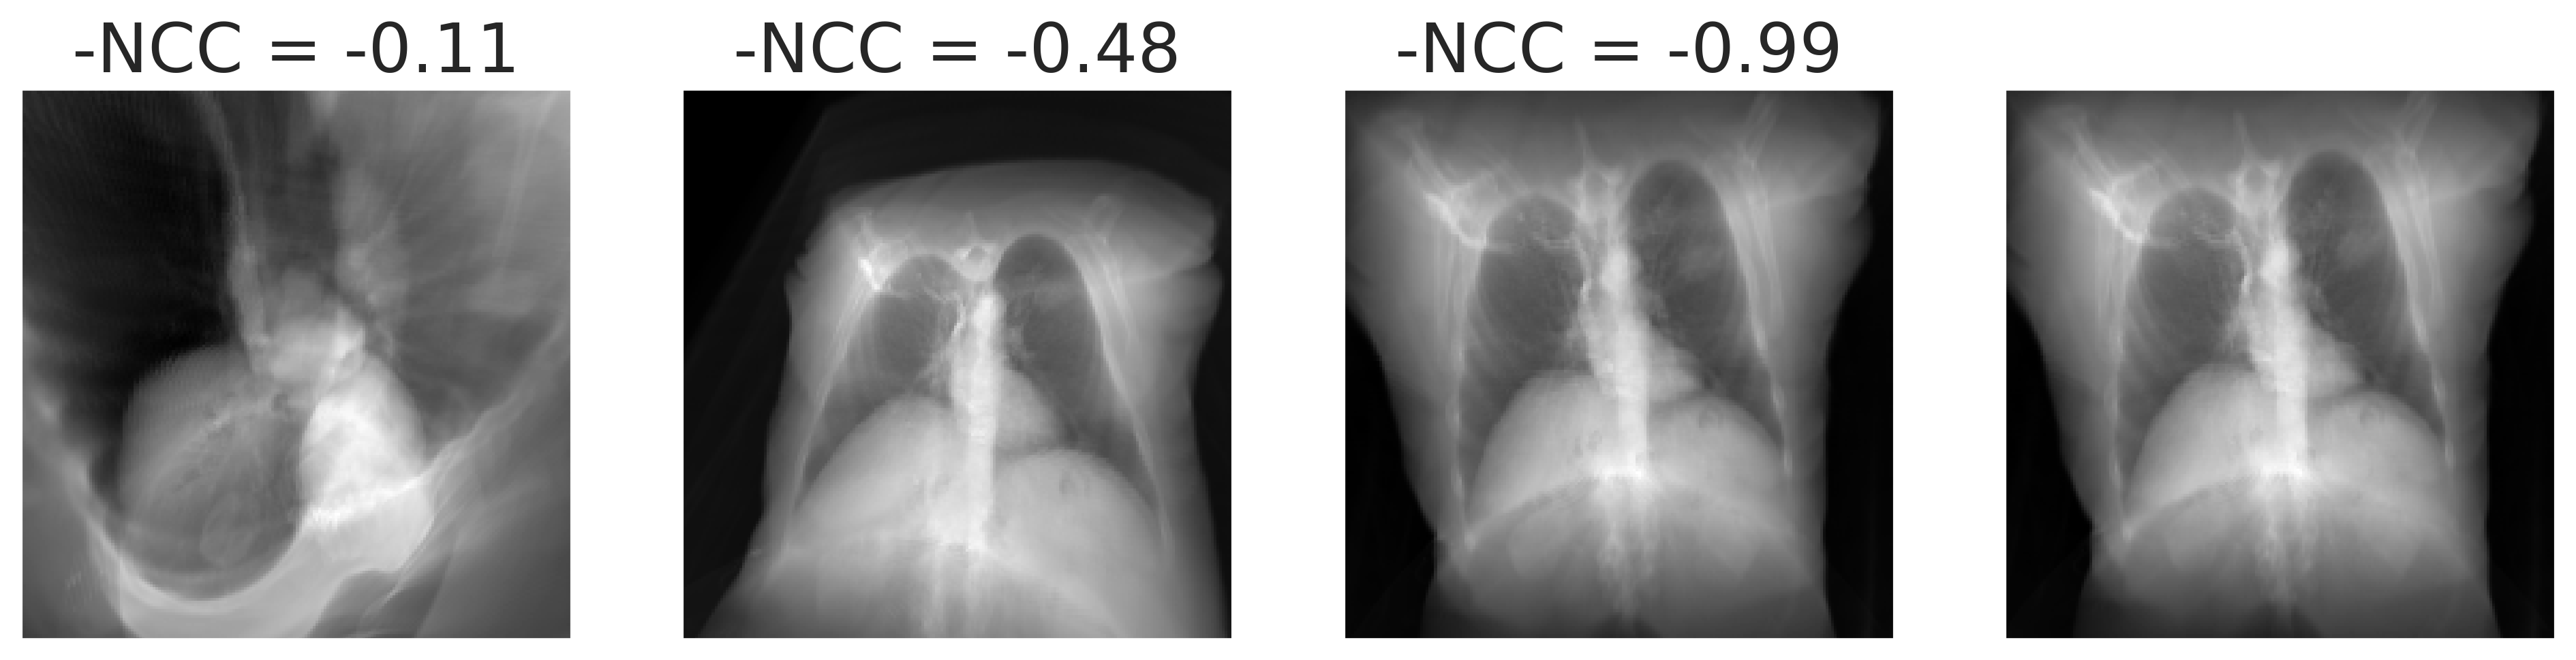

In [40]:
plot_est("../results/grad_desc/263.csv", 25, "../figures/converged-2.pdf")

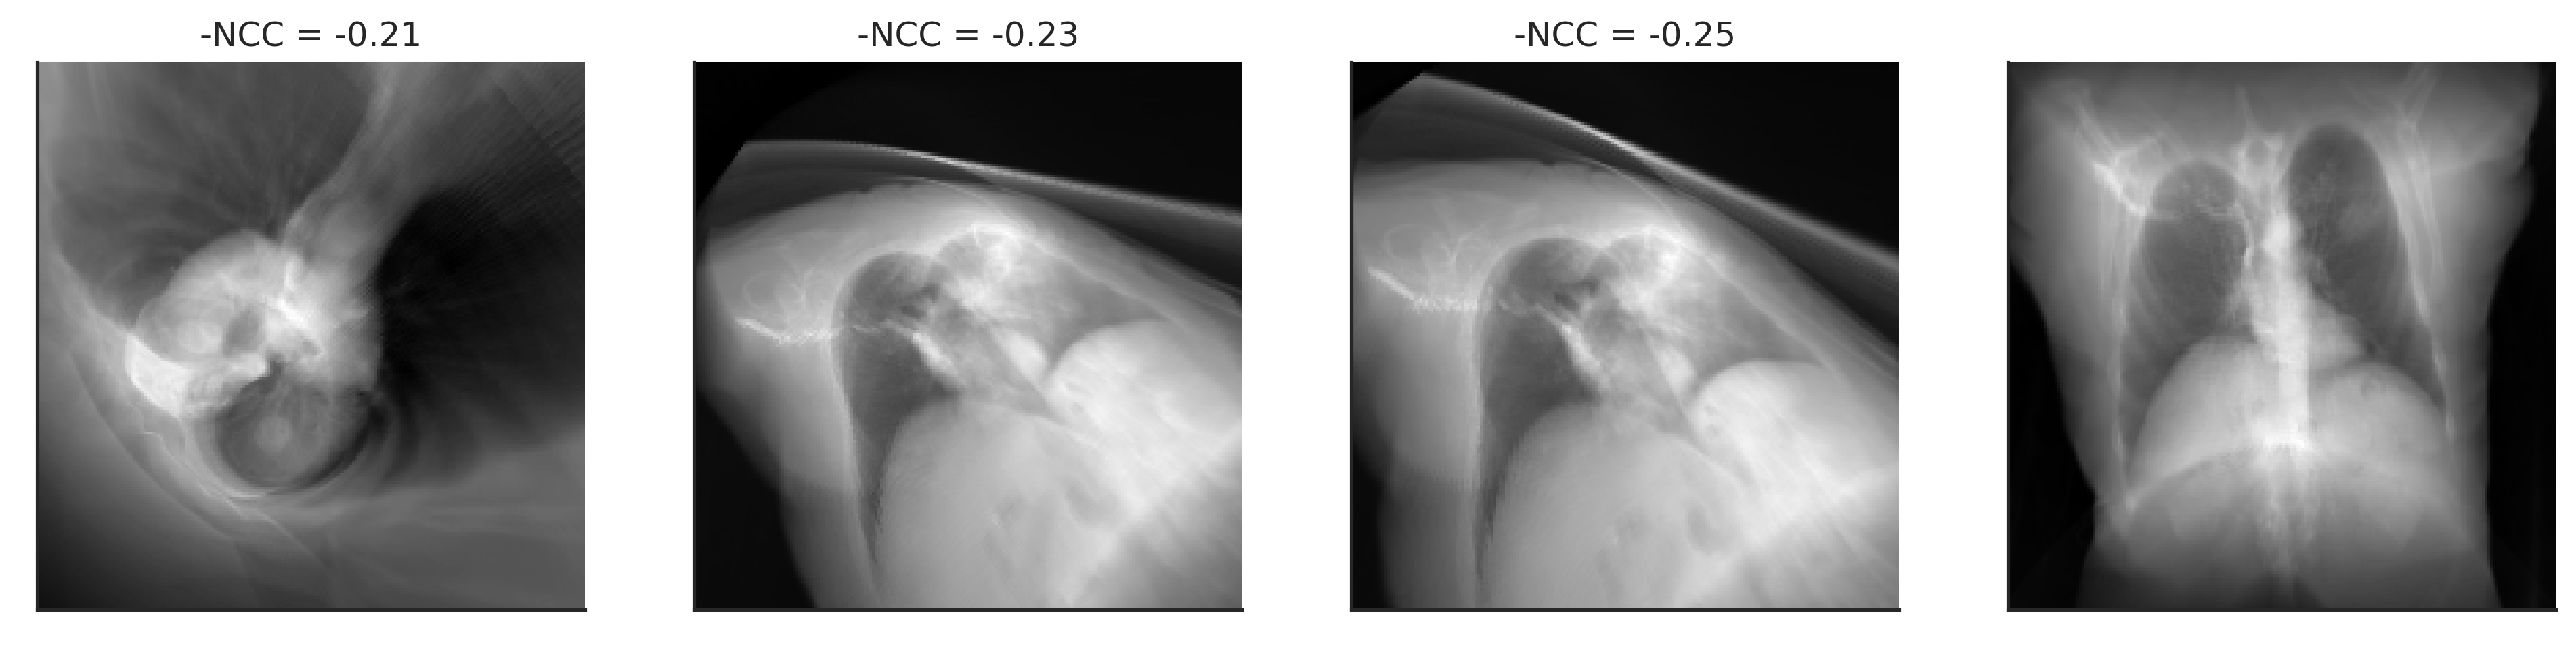

In [71]:
plot_est("../results/grad_desc/370.csv", 150, "../figures/case3.pdf")

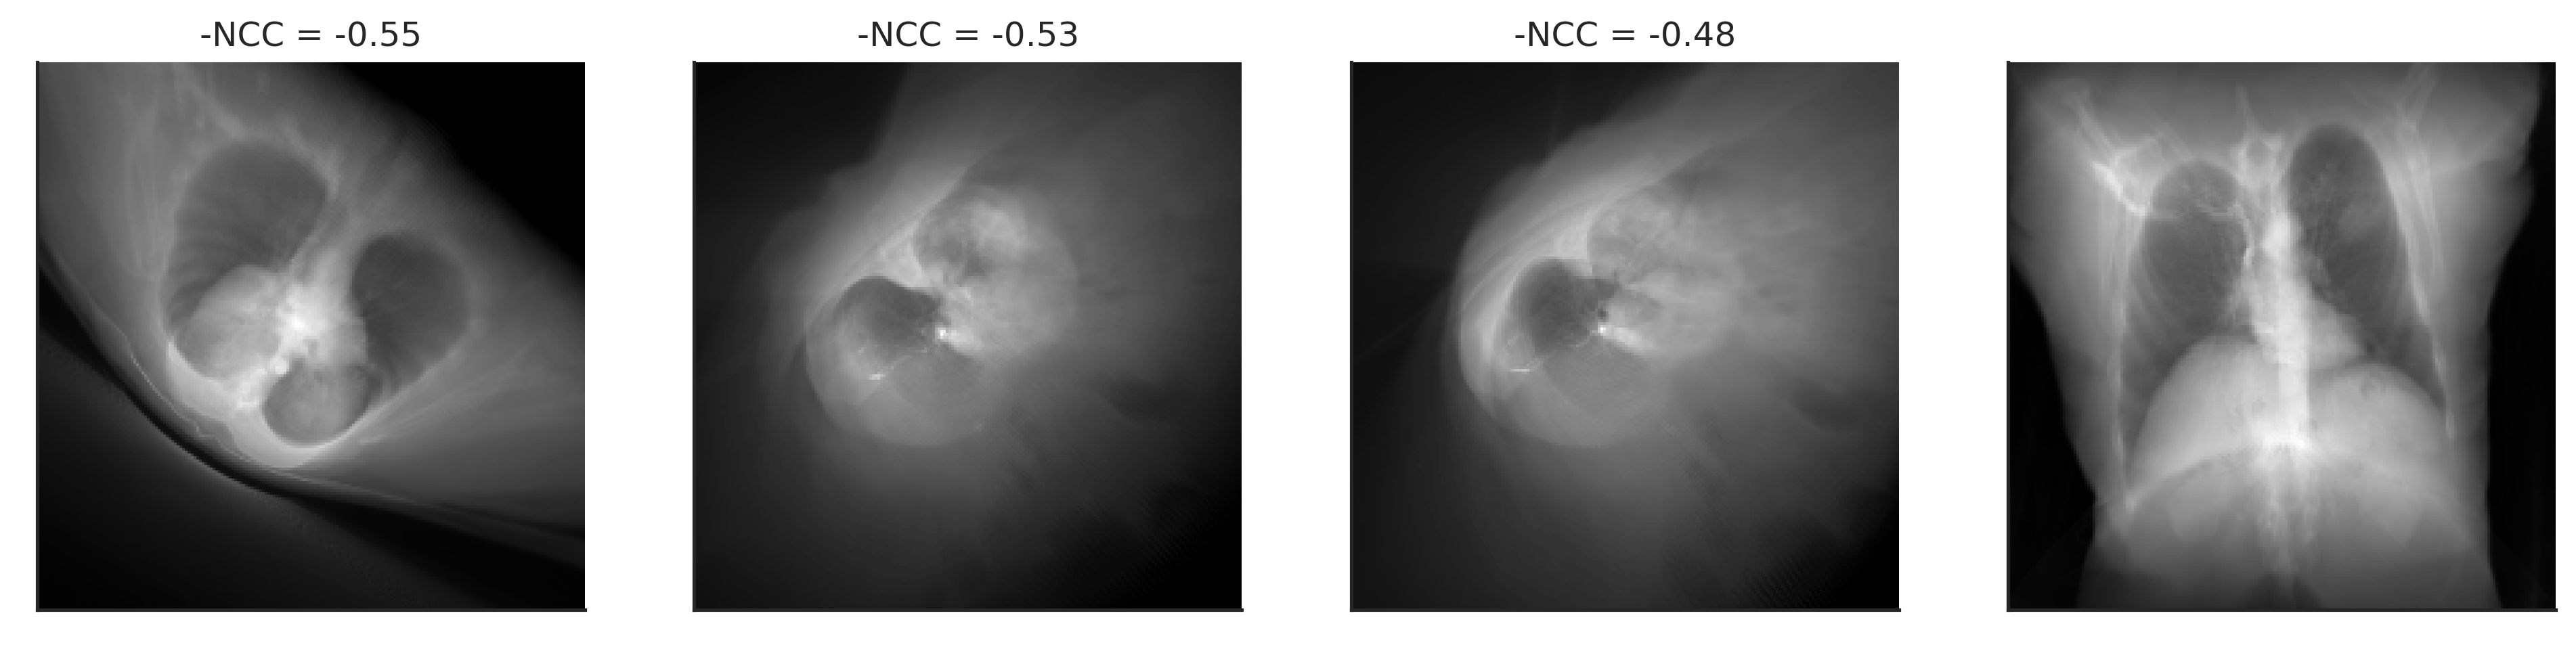

In [72]:
plot_est("../results/grad_desc/446.csv", 50, "../figures/case2.pdf")

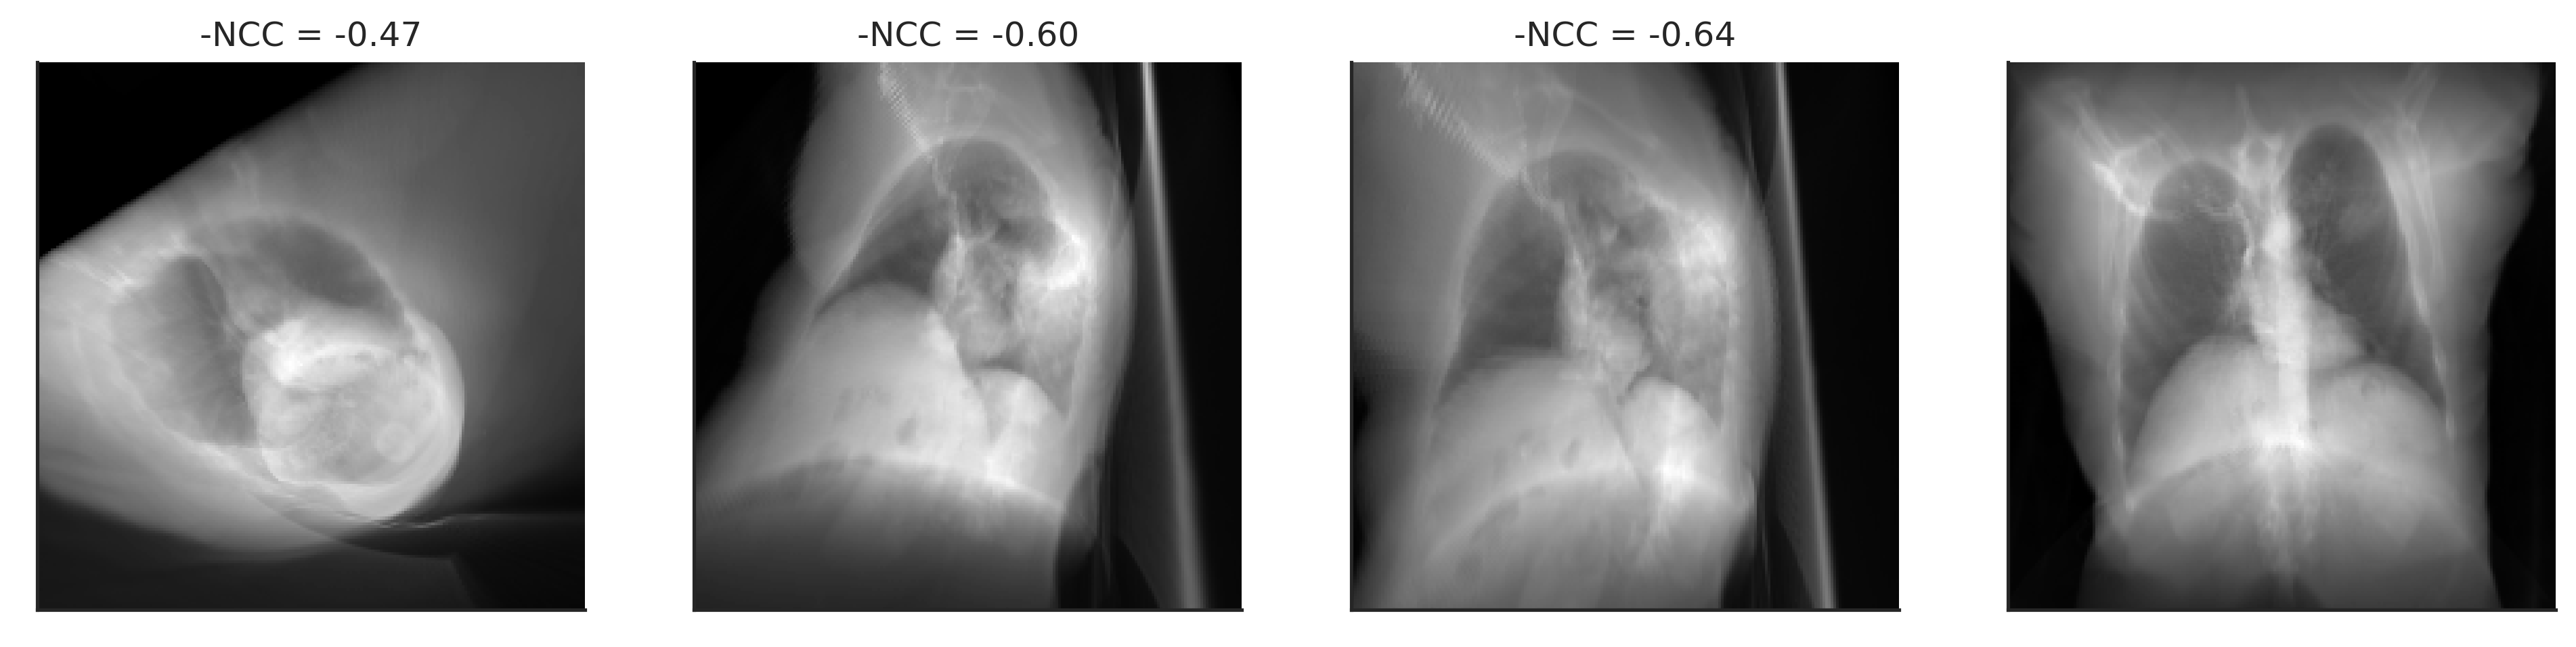

In [73]:
plot_est("../results/grad_desc/27.csv", 50, "../figures/case1-1.pdf")

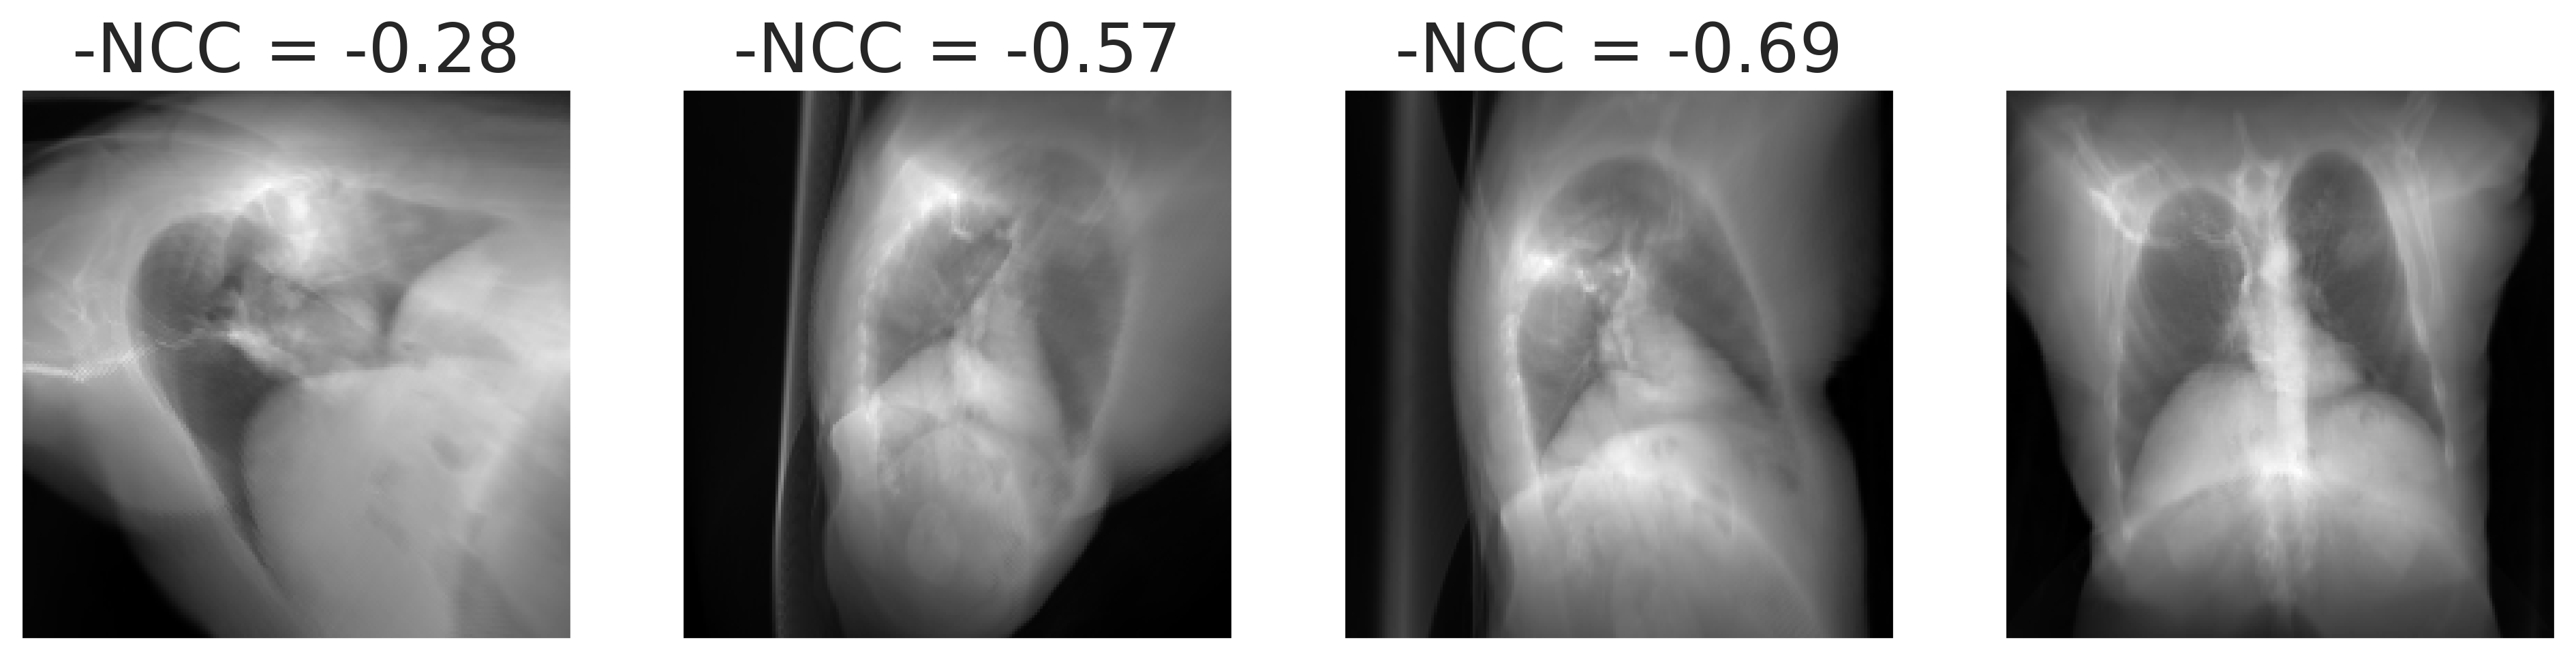

In [41]:
plot_est("../results/grad_desc/29.csv", 50, "../figures/case1-2.pdf")